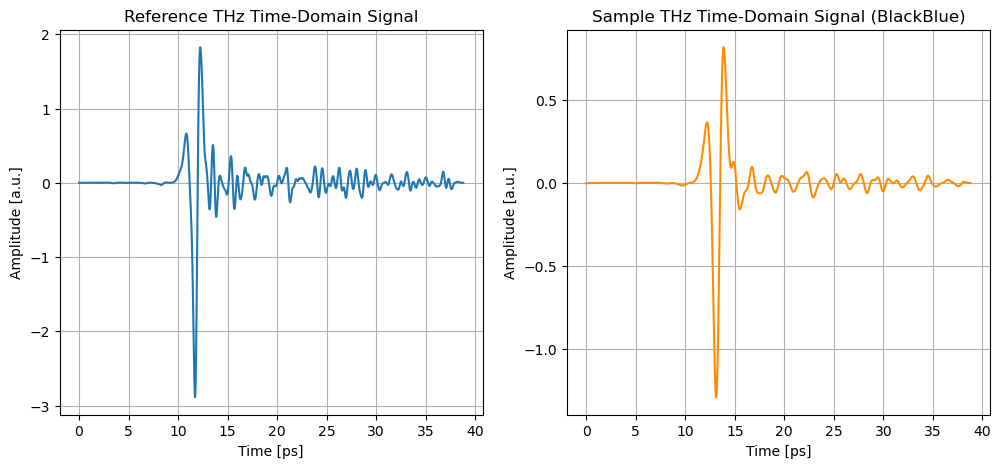

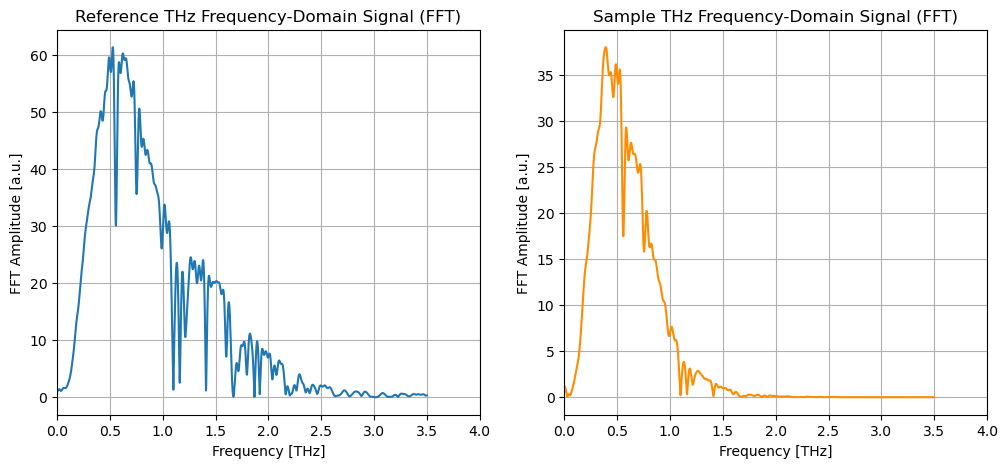

In [5]:
import numpy as np 
import matplotlib.pyplot as plt



# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"D:\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Ref2.txt",dtype=float)

# INSERT SAMPLE DATA
blackblue_pulse = np.loadtxt(r"D:\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data\Black_Blue.txt",dtype=float)

t1= reference_pulse[:,0] + 733.8  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 =blackblue_pulse[:,0] + 733.8  # ADJUISTING THE AXIS
amp2 = blackblue_pulse[:,1]

# FFT OF SIGNALS
reference_fft = np.fft.fft(amp1,16384)
sample_fft = np.fft.fft(amp2,16384)

time_step = t1[1] - t1[0]
frequency = np.fft.fftfreq(16384, d=time_step*1e-12)  # Convert ps to s for frequency calculation


# MASK
mask = (frequency > 0) & (frequency < 3.5 * 10**12)
reference_fft = reference_fft[mask]
sample_fft = sample_fft[mask]
frequency = frequency[mask]

# PLOTTING REFERENCE AND SAMPLE SIGNALS


# PLOTS
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1,amp1)
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Reference THz Time-Domain Signal')
plt.grid()  
plt.subplot(1,2,2)
plt.plot(t2,amp2, color='darkorange')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Sample THz Time-Domain Signal (BlackBlue)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(frequency*1e-12,np.abs(reference_fft))
plt.xlim(0,4)
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Reference THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.subplot(1,2,2)
plt.plot(frequency*1e-12,np.abs(sample_fft), color='darkorange')
plt.xlim(0,4)
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Sample THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.show()

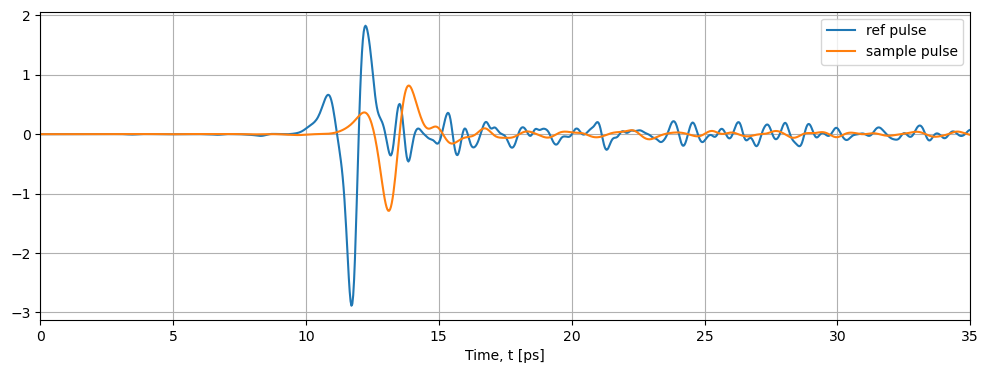

In [6]:
import torch
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.Simulate import simulate_parallel

# BAYES AND ADAM EXTRACTION

# CONVERT DATA TO TENSORS

# REFERENCE PULSE
reference_pulse_tensor = torch.tensor(amp1, dtype=torch.float32)
#SAMPLE PULSE
sample_pulse_tensor = torch.tensor(amp2, dtype=torch.float32)


plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(),label='ref pulse')
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),label='sample pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.xlim(0,35)
plt.grid()
plt.show()

Delta t:  0.03299319999996442
Number of time points, L:  1177
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.5999999999999999, 2.1999999999999997)
Layer 1 - k ∈ (-0.0115, 0.0085)
Layer 1 - D ∈ (0.00019050000000000002, 0.0002095)
Layer 2 - k ∈ (-0.011, 0.009000000000000001)
Layer 2 - D ∈ (-4.5e-06, 1.45e-05)
Layer 3 - n ∈ (1.44, 2.04)
Layer 3 - k ∈ (-0.0115, 0.0085)
Layer 3 - D ∈ (0.0004905, 0.0005095)
[((2.0779257921161394-0.007831304202676723j), 0.00020531412900518263), ((1+0.0009370031589297431j), 3.970822304218234e-06), ((1.4999849494908017-0.0023150221606826546j), 0.0004968404636116414)]


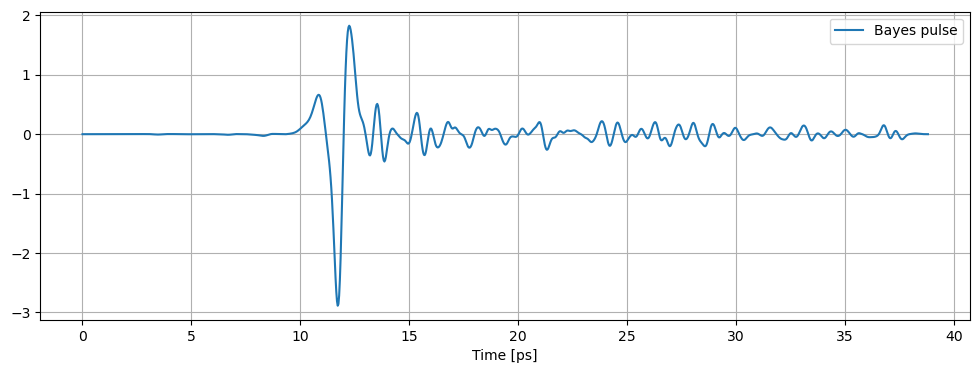

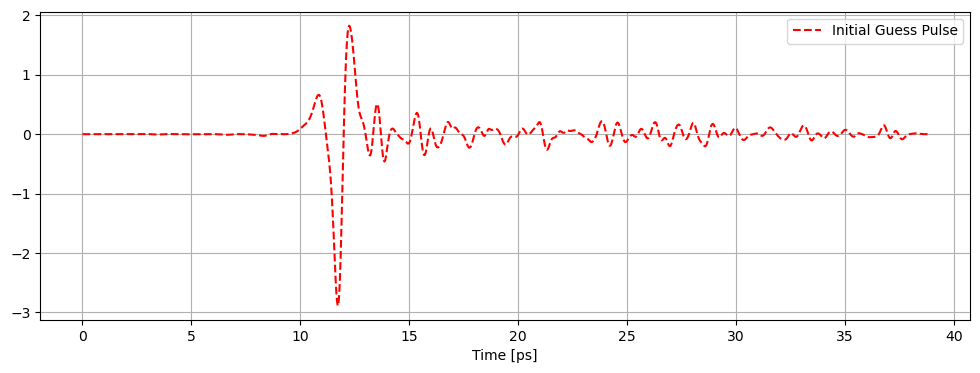

In [9]:
# set initial guesses for Bayes optimization
layers_init = [(1.9-0.0015j, 0.2e-3),(1-0.001j,5e-6),(1.74-0.0015j,0.5e-3)] 

optimization_bounds = [0.3, 0.01, 9.5e-6]
deltat = t1[1] - t1[0]
L = reference_pulse_tensor.shape[0]

initial_pulse = simulate_parallel(reference_pulse_tensor, layers_init, deltat)[1].detach().cpu().numpy()[:L]
print("Delta t: ", deltat)
print("Number of time points, L: ", L)

# Set optimization mask
optimization_mask = [(True, True, True),
                     (False, True, True),
                     (True, True, True)]

# Initialize extractor for the data
Bayes_extractor = BayesianLayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, layers_init,optimization_mask, optimization_bounds=optimization_bounds)

# Run the extraction loop and returns parameters

bayes_params = ms = Bayes_extractor.bayesian_optimization(n_calls=50)





# Run forward pass with Jeff’s model
bayes_pulse = simulate_parallel(reference_pulse_tensor,bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

 # Print the parameters
print(bayes_params)

 # plot the bayes pulse
plt.figure(figsize=(12,4))
plt.plot(t1, bayes_pulse, label='Bayes pulse', linestyle='-')
plt.xlabel('Time [ps]')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t1, initial_pulse, label='Initial Guess Pulse', linestyle='--',color='red')
plt.xlabel('Time [ps]')
plt.grid(True)
plt.legend()
plt.show()




Fine-tuning 8 parameters for 300 iterations.
Iteration 49, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00783, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00232, D=496.84 µm
Iteration 99, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00783, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00232, D=496.84 µm
Iteration 149, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00783, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00232, D=496.84 µm
Iteration 199, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00783, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00232, D=496.84 µm
Iteration 249, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00784, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00232, D=496.84 µm
Iteration 299, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00784, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n

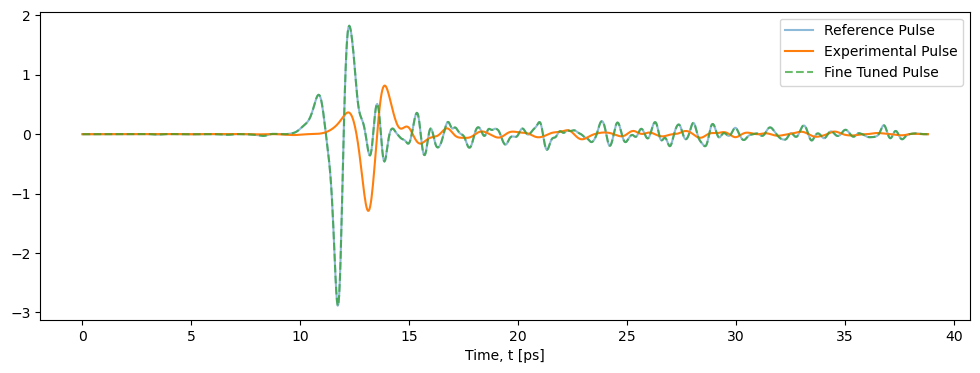

In [10]:
 # Initialize adam optimizer object
grad_optimizer = LayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, bayes_params,optimization_mask, lr=0.0001)
 # Run optimization for set iterations, ‘updates’ provides a printout of progress
optim_params = grad_optimizer.optimize(num_iterations=300,updates=50)
optim_pulse = simulate_parallel(reference_pulse_tensor,
optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',
alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Experimental Pulse')
plt.plot(t1, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend() 
plt.show()


In [12]:
print("The final parameters given by the extraction are:")
print(optim_params)

The final parameters given by the extraction are:
[((2.077925682067871-0.007831322029232979j), 0.00020531407790258527), ((1+0.0009370030020363629j), 3.97082067138399e-06), ((1.4999849796295166-0.0023150534834712744j), 0.0004968404537066817)]


Fine-tuning 9 parameters for 100 iterations.
Iteration 4, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00784, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00233, D=496.84 µm
Iteration 9, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00785, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00235, D=496.84 µm
Iteration 14, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00786, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00236, D=496.84 µm
Iteration 19, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00787, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00238, D=496.84 µm
Iteration 24, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00788, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.5000, k=-0.00239, D=496.84 µm
Iteration 29, Loss: 3.705276e-01, Layer 0: n=2.0779, k=-0.00789, D=205.31 µm | Layer 1: n=1.0000, k=0.00094, D=3.97 µm | Layer 2: n=1.500

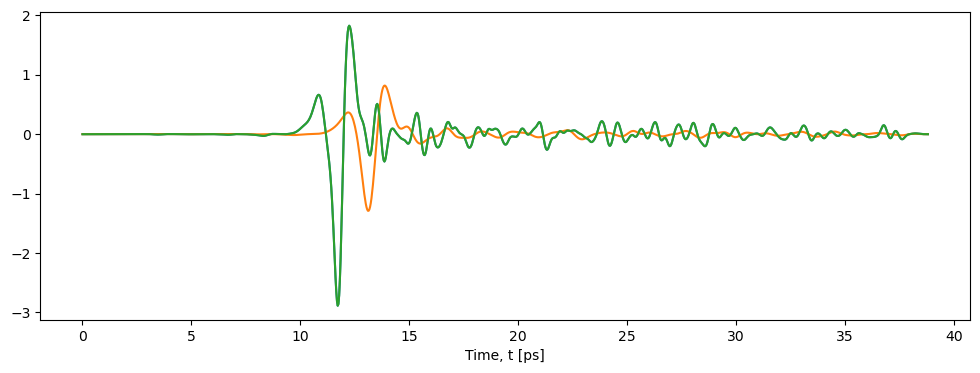

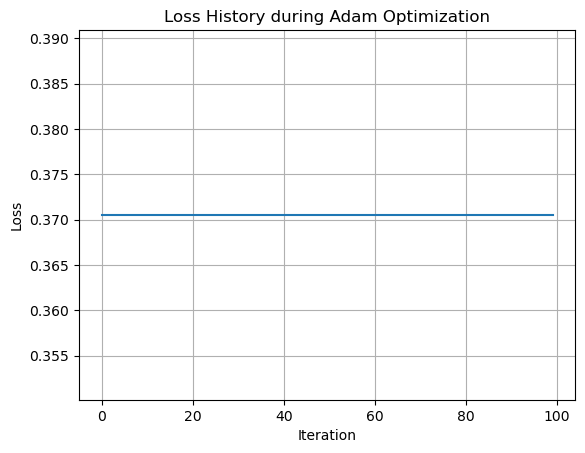

In [14]:
# Use the tensors already created in the notebook (LayeredExtractor expects torch tensors)
LE = LayeredExtractor(reference_pulse_tensor, sample_pulse_tensor, deltat, bayes_params, lr=0.01)
optim_params = LE.optimize(num_iterations=100, updates=5 , alpha=1)

# simulate_parallel returns tensors; get the simulated pulse and convert to numpy
optimal_pulse = simulate_parallel(reference_pulse_tensor, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='ref pulse')
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(), label='exp pulse')
plt.plot(t1, optimal_pulse, label='opt pulse')
plt.xlabel('Time, t [ps]')
plt.show()

plt.plot(LE.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History during Adam Optimization')
plt.grid()
plt.show()